<a href="https://colab.research.google.com/github/richybu/gis_code/blob/main/housingprices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [28]:
from scipy import stats
rng = np.random.default_rng()

In [29]:
from google.colab import files
uploaded = files.upload()

Saving ttest.xlsx to ttest (1).xlsx


In [8]:
from google.colab import files
uploaded = files.upload()

Saving housingchange.xlsx to housingchange (1).xlsx


In [26]:
import io
ttest = pd.read_excel(io.BytesIO(uploaded['housingchange.xlsx']))

KeyError: ignored

In [25]:
import io
housing = pd.read_excel(io.BytesIO(uploaded['housingchange.xlsx']))

KeyError: ignored

In [10]:
housing.columns

Index(['house price', 'income', 'employment', 'health', 'education', 'crime',
       'housing', 'environ'],
      dtype='object')

In [11]:
numeric_col = [ 'income', 'employment', 'health', 'education', 'crime',
       'housing', 'environ']

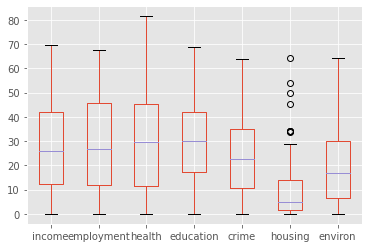

In [12]:
housing.boxplot(numeric_col)

In [13]:
for x in ['housing']:
    q75,q25 = np.percentile(housing.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    housing.loc[housing[x] < min,x] = np.nan
    housing.loc[housing[x] > max,x] = np.nan


In [14]:
housing.isnull().sum()

house price    0
income         0
employment     0
health         0
education      0
crime          0
housing        8
environ        0
dtype: int64

In [15]:
housing = housing.dropna(axis = 0)

In [16]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [17]:
# use VIF on obesity
housing_VIF = drop_column_using_vif_(housing.drop('house price', axis=1))
print("The columns remaining after VIF selection are:")
print(housing_VIF.columns)

Dropping: employment
Dropping: income
The columns remaining after VIF selection are:
Index(['health', 'education', 'crime', 'housing', 'environ'], dtype='object')


In [18]:
#build regression model
model_housing = sm.OLS(endog=housing[['house price']], exog=sm.add_constant(housing_VIF)).fit()
model_housing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     24.11
Date:                Sun, 16 Jan 2022   Prob (F-statistic):           1.38e-15
Time:                        00:30:10   Log-Likelihood:                -332.77
No. Observations:                 101   AIC:                             677.5
Df Residuals:                      95   BIC:                             693.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1455      1.729     11.652      0.000      16.713      23.578
health        -0.1827      0.046     -3.975      0.000      -0.274      -0.091
education     -0.1078      0.073     -1.470      0.145      -0.253       0.038
crime          0.0121      0.067      0.181      0.857      -0.121       0.145
housing        0.4931      0.101      4.882      0.000       0.293       0.694
environ       -0.0904      0.053     -1.706      0.091      -0.196       0.015
==============================================================================
Omnibus:                        5.379   Durbin-Watson:                   2.369
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                4.842
Skew:                           0.425   Prob(JB):                       0.0888
Kurtosis:                       3.653   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

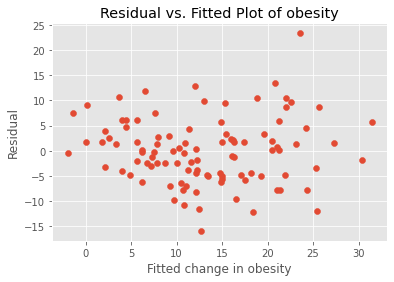

In [19]:
# plot residuals
plt.scatter(model_housing.fittedvalues, model_housing.resid)
# adding title and labels
plt.xlabel('Fitted change in obesity')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of obesity')
plt.show()